In [3]:
import sys, cv2
import numpy as np
import tracktor_revised as tr
import matplotlib.pyplot as plt
import pickle
import os

In [4]:
# Open video file.
video_file        = '../Data/SF_n2_t2_3113.mp4'
cap               = cv2.VideoCapture(video_file)
n_frames          = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps               = cap.get(cv2.CAP_PROP_FPS)
print(f'{n_frames} frames, {fps} frames per second.')

# Contour detection parameters.
block_size,offset = 15,13
min_area,max_area = 20,1000
n_pix             = 5

56214 frames, 30.0 frames per second.


### Creating dataset from file

In [ ]:
# List of frames to analyze.
#frameID_list = range(5000,50000,50)
frameID_list = range(5000,n_frames,1)

# Data structure to hold only the pixels belonging to a fish and their brightness.
fish = []

#Uncomment line to make this cell run, commented to force notebook to use the .pkl file for speed. (This cell takes over an hour.)
#for i in frameID_list:
    
    # Load the frame.
    cap.set(cv2.CAP_PROP_POS_FRAMES, i-1)
    ret,frame = cap.read()
    
    # Detect the contours.
    contours  = tr.contour_detect(frame,min_area,max_area,block_size,offset,n_pix)
    
    # Make a mask with value j inside fish number j and -1 elsewhere. 
    mask      = 0*cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY) - 1
    for j in range(len(contours)):
        cv2.drawContours(mask, contours, j, j, -1)
    
    # Make and save a list of each fish's pixels.
    pixels=[]
    subFish=[]
    for j in range(len(contours)):
        pixels=(np.nonzero(mask==j))
        n =len(pixels[0]) # Number of pixels in J
        subSubFish=[]
        for k in range(n):
            row=pixels[0][k]
            col=pixels[1][k]
            rgb=frame[row,col]
            grey=round(.3*rgb[0]+.59*rgb[1]+.11*rgb[2],2)
            subSubFish.append([row,col,grey]) #Pixel
        subFish.append(np.array(subSubFish)) #Fish
    fish.append(subFish) #Frame

with open('fish.pkl','wb') as fh:
     pickle.dump(fish,fh)

In [5]:
with open('fish.pkl','rb') as fh:
     fish=pickle.load(fh)

### Graphs

Creates a histogram of 

In [ ]:
bins=np.linspace(0,256,20)
plt.figure(figsize=(10,10))
colorList=['r','b']
xlabel=('')
ylabel=('')
for i in range(len(fish)):
    for j in range(len(fish[i])):
        histArray=np.histogram(fish[i][j][:,2],bins=bins)
        plt.plot(histArray[1][:-1],histArray[0],color=colorList[j])
plt.show()

Creates an array of the distance, brightness sum and brightness difference for the frame of greyFish

In [ ]:
pairFrameData=[]
for i in range(len(fish)):
    for j in range(i):
        distance=np.sqrt((fish[i][0][0]-fish[j][0][0])**2+(fish[i][0][1]-fish[j][0][1])**2)
        brightness=fish[i][0][2]+fish[j][0][2]
        difference=np.absolute(fish[i][0][2]-fish[j][0][2])
        pairFrameData.append([distance,brightness,difference])
pairFrameData=np.array(pairFrameData).T
print(pairFrameData)

Creates a 2d histogram of the first frame of greyFish using sum then difference of brightnesses

In [ ]:
histArray=np.histogram(pairFrameData[0])
plt.plot(histArray[1][:-1],histArray[0])
plt.show()

heightValuesSum,bin1Sum,bin2sum=np.histogram2d(pairFrameData[0],pairFrameData[1])
plt.hist2d(pairFrameData[0],pairFrameData[1])
plt.show()

heightValuesDifference,bin1Difference,bin2Difference=np.histogram2d(pairFrameData[0],pairFrameData[2])
plt.hist2d(pairFrameData[0],pairFrameData[2])
plt.show()

Creates an array of the distance difference[0], brightness sum[1], and brightness difference[2] for every frame of greyFish

In [ ]:
#Creates an array of the distance difference[0], brightness sum[1], and brightness difference[2] for every frame of greyFish
bins=np.linspace(0,500,20)
histDifferenceData=[]
for k in range(len(greyFish)):
    pairsData=[]
    for i in range(greyFish[k].shape[1]):
        for j in range(i):
            distance=np.sqrt((greyFish[k][0][i]-greyFish[k][0][j])**2+(greyFish[k][1][i]-greyFish[k][1][j])**2)
            brightness=greyFish[k][2][i]+greyFish[k][2][j]
            difference=np.absolute(greyFish[k][2][i]-greyFish[k][2][j])
            pairsData.append([distance,brightness,difference])
    pairsData=np.array(pairsData).T
    histDifferenceData.append(np.histogram2d(pairsData[0],pairsData[2],bins=[bin1Difference,bin2Difference]))

In [ ]:
#Calculates the euclidan difference between the first frame of histDifferenceData and every other frame using: the distance in [0], the brightnes sums in [1], and the brightness diffrerence in [2]
twodDifferenceArray=[]
for i in range(len(histDifferenceData)):
    twodDifferenceSubArray=[]
    twodDifferenceSubArray=np.linalg.norm(histDifferenceData[i][0]-histDifferenceData[0][0])
    twodDifferenceArray.append(twodDifferenceSubArray)

In [ ]:
#Plots histogram of distance values
histArray=np.histogram(twodDifferenceArray)
plt.plot(histArray[1][:-1],histArray[0])
plt.show()

### Fish Overlap Check

In [6]:
crossedList=[]
for i in range(len(fish)):
    if len(fish[i])==1:
        crossedList.append(i)

nonoverlappingRanges=[]
overlappingRanges=[]
#for i in range(len(fish)): 
i=0
#while i < len(fish):
while i < 51212:
    #print(i)
    crossedSubList2=[]
    if len(fish[i])!=1:
        for j in range(len(fish[i:-1])):
            if len(fish[i+j])!=1:
                crossedSubList2.append(i+j)
            else:
                break
        if i>=0:
            i=i+j
        else:
            i=i+1
        nonoverlappingRanges.append([crossedSubList2[0],crossedSubList2[-1]])
        #print(crossedSubList2)
    else:
        i=i+1
#print(nonoverlappingRanges)

for i in range(len(nonoverlappingRanges)-1):
    overlappingRanges.append([nonoverlappingRanges[i][-1]+1,nonoverlappingRanges[i+1][0]-1])
    continue
#print(overlappingRanges)

In [24]:
crossedSubList2=[]
i=51212
while i<=51214:
    for j in range(len(fish[i:-1])):
        if len(fish[i+j])!=1:
            crossedSubList2.append(i+j)
            print(i+j)
            print(fish[i:-1])
        else:
            break
    i+=1
print(crossedSubList2)

51212
[[array([[295.  , 432.  , 150.49],
       [295.  , 433.  , 147.49],
       [295.  , 434.  , 149.01],
       [295.  , 435.  , 150.01],
       [296.  , 433.  , 151.49],
       [296.  , 434.  , 149.49],
       [296.  , 435.  , 150.49],
       [296.  , 436.  , 150.49],
       [296.  , 437.  , 147.49],
       [296.  , 438.  , 149.49],
       [296.  , 439.  , 150.49],
       [297.  , 435.  , 150.49],
       [297.  , 436.  , 143.49],
       [297.  , 437.  , 145.49],
       [297.  , 438.  , 141.49],
       [297.  , 439.  , 140.49],
       [297.  , 440.  , 138.5 ],
       [297.  , 441.  , 143.5 ],
       [297.  , 442.  , 144.5 ],
       [298.  , 437.  , 152.49],
       [298.  , 438.  , 143.01],
       [298.  , 439.  , 137.01],
       [298.  , 440.  , 137.02],
       [298.  , 441.  , 138.02],
       [298.  , 442.  , 138.02],
       [298.  , 443.  , 140.02],
       [298.  , 444.  , 140.49],
       [298.  , 445.  , 140.49],
       [299.  , 439.  , 148.01],
       [299.  , 440.  , 142.02],
  

In [7]:
#Take a list of each strech where the fish don't cross so that we can check which fish is which after they cross by comparing it to either the first or the longest streach uncrossed
#See 1 on fily's paper
longestDistance=[]
distance=0
for i in range(len(crossedList)):
    if (crossedList[i]-crossedList[i-1])>distance:
        distance=(crossedList[i]-crossedList[i-1])
        longestDistance=[distance,i,crossedList[i],crossedList[i-1]]
print(longestDistance)

[2482, 628, 26589, 24107]


In [8]:
#finding the center of each fish
#2 on fily's paper
fishMean=[]
for i in range(len(fish)):
    if len(fish[i])==1:
        fishMean.append([[np.mean(fish[i][0].T[0]),np.mean(fish[i][0].T[1])],[np.mean(fish[i][0].T[0]),np.mean(fish[i][0].T[1])]])
    else:
        fishMean.append([[np.mean(fish[i][0].T[0]),np.mean(fish[i][0].T[1])],[np.mean(fish[i][1].T[0]),np.mean(fish[i][1].T[1])]])
fishMean=np.asarray(fishMean)
#fishMean[i.j.k] is the coordianate of k of the position of fjsh j in frame i

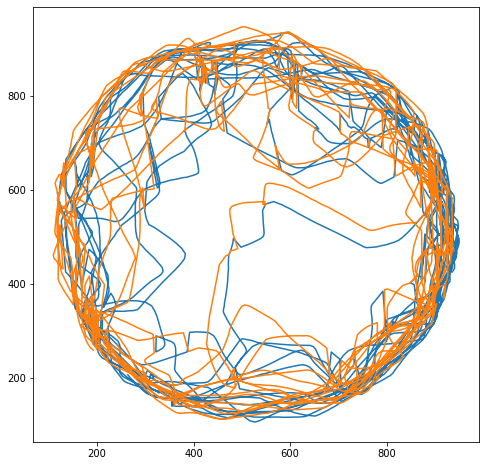

In [9]:
plt.figure(figsize=(8,8))
I = slice(0,5000)
plt.plot(fishMean[I,0,0],fishMean[I,0,1])
plt.plot(fishMean[I,1,0],fishMean[I,1,1])
plt.show()

In [17]:
#create array of distances between two fishes to find switching
#[[i,0-i+1,0][i,1-i+1,1][i,0-i+1,1][i,1-i+1,0]]
fishQuad=[]
fishQuadDistance=[]
for i in range(len(fishMean)-1):
    fishQuad.append([fishMean[i+1][0]-fishMean[i][0],fishMean[i+1][1]-fishMean[i][1],fishMean[i+1][1]-fishMean[i][0],fishMean[i+1][0]-fishMean[i][1]])
    fishQuadDistance.append([abs(np.sqrt(abs((fishMean[i+1][0][0]-fishMean[i][0][0])**2+(fishMean[i+1][0][1]-fishMean[i][0][1])**2))-np.sqrt(abs((fishMean[i+1][1][0]-fishMean[i][1][0])**2+(fishMean[i+1][1][1]-fishMean[i][1][1])**2))),abs(np.sqrt(abs((fishMean[i+1][0][0]-fishMean[i][1][0])**2+(fishMean[i+1][0][1]-fishMean[i][0][1])**2))-np.sqrt(abs((fishMean[i+1][1][0]-fishMean[i][1][0])**2+(fishMean[i+1][1][1]-fishMean[i][0][1])**2)))])
print(np.asarray(fishQuadDistance[0:10]))
print(np.array(fishQuadDistance).shape)

[[ 6.33055292 32.96158006]
 [ 6.33323856 32.60556489]
 [ 6.56219383 32.93001886]
 [11.14783034 24.45385815]
 [ 5.666198   32.02646255]
 [ 4.64663605 31.03869326]
 [ 5.46407282 27.448227  ]
 [ 7.18606262 20.19510573]
 [ 3.91395146 10.56577376]
 [ 0.         15.87755938]]
(51213, 2)


In [16]:
fishQuad=[]
fishQuadDistance=[]
for i in range(len(overlappingRanges)-1):
    fishQuad.append([fishMean[overlappingRanges[i][0]+1][0]-fishMean[overlappingRanges[i][0]][0],fishMean[overlappingRanges[i][1]+1][1]-fishMean[overlappingRanges[i][1]][1],fishMean[overlappingRanges[i][1]+1][1]-fishMean[overlappingRanges[i][0]][0],fishMean[overlappingRanges[i][0]+1][0]-fishMean[overlappingRanges[i][1]][1]])
    fishQuadDistance.append([abs(np.sqrt(abs((fishMean[i+1][0][0]-fishMean[i][0][0])**2+(fishMean[i+1][0][1]-fishMean[i][0][1])**2))-np.sqrt(abs((fishMean[i+1][1][0]-fishMean[i][1][0])**2+(fishMean[i+1][1][1]-fishMean[i][1][1])**2))),abs(np.sqrt(abs((fishMean[i+1][0][0]-fishMean[i][1][0])**2+(fishMean[i+1][0][1]-fishMean[i][0][1])**2))-np.sqrt(abs((fishMean[i+1][1][0]-fishMean[i][1][0])**2+(fishMean[i+1][1][1]-fishMean[i][0][1])**2)))])
print(np.asarray(fishQuadDistance[0:10]))
print(np.array(fishQuadDistance).shape)

[[ 6.33055292 32.96158006]
 [ 6.33323856 32.60556489]
 [ 6.56219383 32.93001886]
 [11.14783034 24.45385815]
 [ 5.666198   32.02646255]
 [ 4.64663605 31.03869326]
 [ 5.46407282 27.448227  ]
 [ 7.18606262 20.19510573]
 [ 3.91395146 10.56577376]
 [ 0.         15.87755938]]
(249, 2)
